installing packages


In [ ]:
#!pip install deeplake

importing libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

from tqdm.notebook import tqdm
import albumentations as albu
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import imageio
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt



In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
cwd = os.getcwd()

### Downloading the dataset


In [ ]:
import zipfile
import requests

In [ ]:
def extract_file_from_drive(drive_path,path_to_extract):
  from google.colab import drive

  drive.mount('/content/drive')

  zip_ref = zipfile.ZipFile(drive_path, 'r')
  zip_ref.extractall(path_to_extract)
  zip_ref.close()

In [ ]:
zip_file_name = "dataset_Unet.zip"
drive_path = "/content/drive/My Drive/"+zip_file_name 
path_to_extract = os.getcwd()
extract_file_from_drive(drive_path,path_to_extract)

Mounted at /content/drive


device

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(DEVICE)
print(DEVICE)

cpu


In [ ]:
train_imgs = sorted(glob(cwd+"/DRIVE/training/images/*"))
train_bkg = sorted(glob(cwd+"/DRIVE/training/mask/*"))
train_manual_masks = sorted(glob(cwd+"/DRIVE/training/1st_manual/*"))
test_imgs = sorted(glob(cwd+"/DRIVE/test/images/*"))
test_bkg = sorted(glob(cwd+"/DRIVE/test/mask/*"))
test_manual_masks = sorted(glob(cwd+"/DRIVE/test/1st_manual/*"))


In [ ]:
train_imgs

['/content/DRIVE/training/images/21_training.tif',
 '/content/DRIVE/training/images/22_training.tif',
 '/content/DRIVE/training/images/23_training.tif',
 '/content/DRIVE/training/images/24_training.tif',
 '/content/DRIVE/training/images/25_training.tif',
 '/content/DRIVE/training/images/26_training.tif',
 '/content/DRIVE/training/images/27_training.tif',
 '/content/DRIVE/training/images/28_training.tif',
 '/content/DRIVE/training/images/29_training.tif',
 '/content/DRIVE/training/images/30_training.tif',
 '/content/DRIVE/training/images/31_training.tif',
 '/content/DRIVE/training/images/32_training.tif',
 '/content/DRIVE/training/images/33_training.tif',
 '/content/DRIVE/training/images/34_training.tif',
 '/content/DRIVE/training/images/35_training.tif',
 '/content/DRIVE/training/images/36_training.tif',
 '/content/DRIVE/training/images/37_training.tif',
 '/content/DRIVE/training/images/38_training.tif',
 '/content/DRIVE/training/images/39_training.tif',
 '/content/DRIVE/training/image

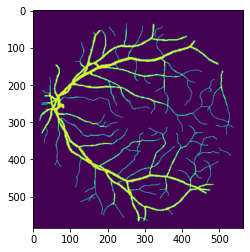

In [ ]:
image = imageio.mimread(train_manual_masks[0])[0]
plt.imshow(image)

Preprocessing

In [ ]:
to_tensor  = transforms.ToTensor()
to_PIL = transforms.ToPILImage()


Data visualisation

In [ ]:
transform = transforms.ToTensor()

In [ ]:
albu_transform = albu.Compose([
    albu.OneOf([
    HorizontalFlip(p=0.8),
    albu.VerticalFlip(p=0.8),
    albu.Rotate(limit=45, p=0.5),
])], p=1.0 )


In [ ]:
image = Image.open(train_imgs[0])
mask = Image.open(train_manual_masks[0])


In [ ]:

os.makedirs(cwd+"/augmented_DRIVE/train/images")
os.makedirs(cwd+"/augmented_DRIVE/train/masks")
os.makedirs(cwd+"/augmented_DRIVE/test/images")
os.makedirs(cwd+"/augmented_DRIVE/test/masks")


In [ ]:
def augment_data(images, masks, save_path, apply_augment=True):
    img_size = transforms.Resize((576,576))
    mask_size = transforms.Resize((576,576))
    
    for idx, (image, mask) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        img_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]
        """ Reading image and mask """
        x = Image.open(image)
        y = Image.open(mask)

        x = img_size(x)
        y = mask_size(y)

        x = np.asarray(x)
        y = np.asarray(y)
        if apply_augment == True:
            hf = HorizontalFlip(p=1.0)
            augmented = hf(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            vf = VerticalFlip(p=1.0)
            augmented = vf(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            r = Rotate(limit=45, p=1.0)
            augmented = r(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for image, mask in zip(X, Y):
            tmp_image_name = f"{img_name}_{index}.png"
            tmp_mask_name = f"{mask_name}_{index}.png"

            image_path = os.path.join(save_path, "images", tmp_image_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            aug_img = to_PIL(image)
            aug_img = aug_img.save(image_path)

            aug_mask = to_PIL(mask)
            aug_mask = aug_mask.save(mask_path)

            index += 1


In [ ]:
augment_data(train_imgs , train_manual_masks, "augmented_DRIVE/train/", apply_augment=True)
augment_data(test_imgs, test_manual_masks, "augmented_DRIVE/test/", apply_augment=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
test_imgs

['/content/DRIVE/test/images/01_test.tif',
 '/content/DRIVE/test/images/02_test.tif',
 '/content/DRIVE/test/images/03_test.tif',
 '/content/DRIVE/test/images/04_test.tif',
 '/content/DRIVE/test/images/05_test.tif',
 '/content/DRIVE/test/images/06_test.tif',
 '/content/DRIVE/test/images/07_test.tif',
 '/content/DRIVE/test/images/08_test.tif',
 '/content/DRIVE/test/images/09_test.tif',
 '/content/DRIVE/test/images/10_test.tif',
 '/content/DRIVE/test/images/11_test.tif',
 '/content/DRIVE/test/images/12_test.tif',
 '/content/DRIVE/test/images/13_test.tif',
 '/content/DRIVE/test/images/14_test.tif',
 '/content/DRIVE/test/images/15_test.tif',
 '/content/DRIVE/test/images/16_test.tif',
 '/content/DRIVE/test/images/17_test.tif',
 '/content/DRIVE/test/images/18_test.tif',
 '/content/DRIVE/test/images/19_test.tif',
 '/content/DRIVE/test/images/20_test.tif']

In [ ]:
test_manual_masks

['/content/DRIVE/test/1st_manual/01_manual1.gif',
 '/content/DRIVE/test/1st_manual/02_manual1.gif',
 '/content/DRIVE/test/1st_manual/03_manual1.gif',
 '/content/DRIVE/test/1st_manual/04_manual1.gif',
 '/content/DRIVE/test/1st_manual/05_manual1.gif',
 '/content/DRIVE/test/1st_manual/06_manual1.gif',
 '/content/DRIVE/test/1st_manual/07_manual1.gif',
 '/content/DRIVE/test/1st_manual/08_manual1.gif',
 '/content/DRIVE/test/1st_manual/09_manual1.gif',
 '/content/DRIVE/test/1st_manual/10_manual1.gif',
 '/content/DRIVE/test/1st_manual/11_manual1.gif',
 '/content/DRIVE/test/1st_manual/12_manual1.gif',
 '/content/DRIVE/test/1st_manual/13_manual1.gif',
 '/content/DRIVE/test/1st_manual/14_manual1.gif',
 '/content/DRIVE/test/1st_manual/15_manual1.gif',
 '/content/DRIVE/test/1st_manual/16_manual1.gif',
 '/content/DRIVE/test/1st_manual/17_manual1.gif',
 '/content/DRIVE/test/1st_manual/18_manual1.gif',
 '/content/DRIVE/test/1st_manual/19_manual1.gif',
 '/content/DRIVE/test/1st_manual/20_manual1.gif']

In [ ]:
#import shutil
#shutil. rmtree(cwd+'/augmented_DRIVE/')   #<- Useful to remove a non-empty folder as well as it subfolders and files 

In [ ]:
class ImageFolderCustom(torch.utils.data.Dataset):
    
    def __init__(self, image_dir, masks_dir,transform = None ):
        self.image_paths = sorted(list(image_dir.glob("*.png")))
        self.masks_paths = sorted(list(masks_dir.glob("*.png")))
        self.transform = transform

    def load_image(self, index: int) -> Image.Image:
        image_path = self.image_paths[index]
        mask_path = self.masks_paths[index]
        return Image.open(image_path), Image.open(mask_path)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img, mask = self.load_image(index)

        #albumentations take arrays as parameters so we have at first time to transform our image and mask to ndarrays
        x = np.asarray(img)
        y = np.asarray(mask)

        img_array = x/255.0 ## (H,W,n_C) where each pixel is in range [0,1]
        img_array = img_array.astype(np.float32)

        mask_array = y/255.0 ## (H,W,n_C) where each pixel is in range [0,1]
        mask_array = mask_array.astype(np.float32)

        img = self.transform(img_array)
        mask = self.transform(mask_array)
        return img, mask

In [ ]:
train_img_dir = Path(os.path.join(cwd,"augmented_DRIVE","train","images"))
train_mask_dir =  Path(os.path.join(cwd,"augmented_DRIVE","train","masks")) 
test_img_dir =  Path(os.path.join(cwd,"augmented_DRIVE","test","images"))
test_mask_dir =  Path(os.path.join(cwd,"augmented_DRIVE","test","masks"))

In [ ]:
train_dataset = ImageFolderCustom(image_dir=train_img_dir,
                                  masks_dir=train_mask_dir, 
                                 transform = transform)

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=1, 
                              num_workers=0, 
                              shuffle=True)



In [ ]:
test_dataset = ImageFolderCustom(image_dir=test_img_dir,
                                  masks_dir=test_mask_dir, 
                                 transform = transform)

test_dataloader = DataLoader(dataset=test_dataset, 
                              batch_size=1, 
                              num_workers=0, 
                              shuffle=True)

Buid dataset

MODEL(UNET)

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
        )
        
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=1, in_channels=mid_channel, out_channels=out_channels),
                    torch.nn.ReLU(),
                    )
            return  block  
    
    def crop(self, upsampled, old, channels, square):
        c = (old.size()[2] - upsampled.size()[2]) // 2
        out = F.pad(old, (-c,-c,-c,-c))


        return torch.stack((out, upsampled), dim=1).reshape(shape=(1, channels,square,square))
    
    def crop2(self, upsampled, old, channels, square):
        c = (old.size()[2] - upsampled.size()[2]) // 2
        out = F.pad(old, (-c,-c,-c,-c))
        
        return torch.cat((upsampled, out), 1)
    
    def __init__(self, in_channel, out_channel):
        super().__init__()
        
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_encode4 = self.contracting_block(256, 512)
        self.conv_maxpool4 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_encode5 = self.contracting_block(512, 1024)

        #decode
        self.upconv1 = torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dconv1 = self.contracting_block(1024, 512)
        
        self.upconv2 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dconv2 = self.contracting_block(512, 256)
        
        self.upconv3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dconv3 = self.contracting_block(256, 128)

        self.upconv4 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_layer = self.final_block(128, 64, out_channel)
        
 
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        
        encode_block4 = self.conv_encode4(encode_pool3)
        encode_pool4 = self.conv_maxpool4(encode_block4)
        
        encode_block5 = self.conv_encode5(encode_pool4)
        
        #decode
        upconv_block1 = self.upconv1(encode_block5)
        crop_block1 = self.crop2(upconv_block1, encode_block4, 1024, 56)
        dconv_block1 = self.dconv1(crop_block1)
        
        upconv_block2 = self.upconv2(dconv_block1)
        crop_block2 = self.crop2(upconv_block2, encode_block3, 512, 104)
        dconv_block2 = self.dconv2(crop_block2)
        
        upconv_block3 = self.upconv3(dconv_block2)
        crop_block3 = self.crop2(upconv_block3, encode_block2, 256, 200)
        dconv_block3 = self.dconv3(crop_block3)
        
        upconv_block4 = self.upconv4(dconv_block3)
        crop_block4 = self.crop2(upconv_block4, encode_block1, 128, 392)
        
        #final layer
        final_block = self.final_layer(crop_block4)
        
        return  final_block

In [ ]:
from torchsummary import summary

model = UNet(in_channel=3,out_channel=1)

model = model.to(DEVICE)
summary(model,(3,572,572))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 570, 570]           1,792
              ReLU-2         [-1, 64, 570, 570]               0
            Conv2d-3         [-1, 64, 568, 568]          36,928
              ReLU-4         [-1, 64, 568, 568]               0
         MaxPool2d-5         [-1, 64, 284, 284]               0
            Conv2d-6        [-1, 128, 282, 282]          73,856
              ReLU-7        [-1, 128, 282, 282]               0
            Conv2d-8        [-1, 128, 280, 280]         147,584
              ReLU-9        [-1, 128, 280, 280]               0
        MaxPool2d-10        [-1, 128, 140, 140]               0
           Conv2d-11        [-1, 256, 138, 138]         295,168
             ReLU-12        [-1, 256, 138, 138]               0
           Conv2d-13        [-1, 256, 136, 136]         590,080
             ReLU-14        [-1, 256, 1

In [ ]:
from torchsummary import summary

model = smp.Unet(
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(DEVICE)
summary(model,(3,576,576))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 288]           9,408
       BatchNorm2d-2         [-1, 64, 288, 288]             128
              ReLU-3         [-1, 64, 288, 288]               0
         MaxPool2d-4         [-1, 64, 144, 144]               0
            Conv2d-5         [-1, 64, 144, 144]          36,864
       BatchNorm2d-6         [-1, 64, 144, 144]             128
              ReLU-7         [-1, 64, 144, 144]               0
            Conv2d-8         [-1, 64, 144, 144]          36,864
       BatchNorm2d-9         [-1, 64, 144, 144]             128
             ReLU-10         [-1, 64, 144, 144]               0
       BasicBlock-11         [-1, 64, 144, 144]               0
           Conv2d-12         [-1, 64, 144, 144]          36,864
      BatchNorm2d-13         [-1, 64, 144, 144]             128
             ReLU-14         [-1, 64, 1

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
  
    train_loss= 0
  
    for batch, (image, mask) in enumerate(dataloader):
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()
        output = model(image)

        loss = loss_fn(output, mask)
        loss.backward()

        optimizer.step()
        train_loss += loss.item() 

        



    train_loss = train_loss / len(dataloader)
    return train_loss

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval() 
  
    test_loss = 0
    with torch.no_grad():
        for i, (image, mask) in enumerate(dataloader):
            image = image.to(device)
            mask = mask.to(device)
            output = model(image)
            loss = loss_fn(output, mask)
            test_loss += loss.item()
    test_loss /=len(dataloader)
    return test_loss

In [ ]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs,
          device):
    
    # Create empty results dictionary
    results = {"train_loss": [],
      "test_loss": []
    }
  
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)
      
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
def soft_skeletonize(x, thresh_width=10):
    '''
    Differenciable aproximation of morphological skelitonization operaton
    thresh_width - maximal expected width of vessel
    '''
    for i in range(thresh_width):
        min_pool_x = torch.nn.functional.max_pool2d(x*-1, (3, 3), 1, 1)*-1
        contour = torch.nn.functional.relu(torch.nn.functional.max_pool2d(min_pool_x, (3, 3), 1, 1) - min_pool_x)
        x = torch.nn.functional.relu(x - contour)
    return x

In [ ]:
def norm_intersection(center_line, vessel):
    '''
    inputs shape  (batch, channel, height, width)
    intersection formalized by first ares
    x - suppose to be centerline of vessel (pred or gt) and y - is vessel (pred or gt)
    '''
    smooth = 1.
    clf = center_line.view(*center_line.shape[:2], -1)
    vf = vessel.view(*vessel.shape[:2], -1)
    intersection = (clf * vf).sum(-1)
    return (intersection + smooth) / (clf.sum(-1) + smooth)

In [ ]:
class ClDiceLoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
        super(ClDiceLoss, self).__init__()


  def forward(self,pred, target, target_skeleton=None):
    '''
    inputs shape  (batch, channel, height, width).
    calculate clDice loss
    Because pred and target at moment of loss calculation will be a torch tensors
    it is preferable to calculate target_skeleton on the step of batch forming,
    when it will be in numpy array format by means of opencv
    '''
    cl_pred = soft_skeletonize(pred)
    if target_skeleton is None:
        target_skeleton = soft_skeletonize(target)
    iflat = norm_intersection(cl_pred, target)
    tflat = norm_intersection(target_skeleton, pred)
    intersection = iflat * tflat
    return -((2. * intersection) /
              (iflat + tflat))

In [ ]:
from timeit import default_timer as timer 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn =  ClDiceLoss()

start_time = timer()


model_resulrs = train(model=model, 
      train_dataloader=train_dataloader,
      test_dataloader=train_dataloader,
     optimizer=optimizer,
     loss_fn=loss_fn,
     epochs=50,
     device=DEVICE)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: -1.6315 | test_loss: -1.6464 | 
Epoch: 2 | train_loss: -1.6844 | test_loss: -1.6834 | 
Epoch: 3 | train_loss: -1.7281 | test_loss: -1.7274 | 
Epoch: 4 | train_loss: -1.7579 | test_loss: -1.7461 | 
Epoch: 5 | train_loss: -1.7768 | test_loss: -1.7654 | 
Epoch: 6 | train_loss: -1.7918 | test_loss: -1.7762 | 
Epoch: 7 | train_loss: -1.8047 | test_loss: -1.7891 | 
Epoch: 8 | train_loss: -1.8184 | test_loss: -1.7957 | 
Epoch: 9 | train_loss: -1.8308 | test_loss: -1.8223 | 
Epoch: 10 | train_loss: -1.8407 | test_loss: -1.8261 | 
Epoch: 11 | train_loss: -1.8496 | test_loss: -1.8377 | 
Epoch: 12 | train_loss: -1.8569 | test_loss: -1.8466 | 
Epoch: 13 | train_loss: -1.8634 | test_loss: -1.8548 | 
Epoch: 14 | train_loss: -1.8693 | test_loss: -1.8540 | 
Epoch: 15 | train_loss: -1.8744 | test_loss: -1.8623 | 
Epoch: 16 | train_loss: -1.8792 | test_loss: -1.8628 | 
Epoch: 17 | train_loss: -1.8837 | test_loss: -1.8708 | 
Epoch: 18 | train_loss: -1.8880 | test_loss: -1.8738 | 
E

In [ ]:
train_loss = model_resulrs['train_loss']
test_loss = model_resulrs['test_loss']

epochs = range(1,len(train_loss)+1)

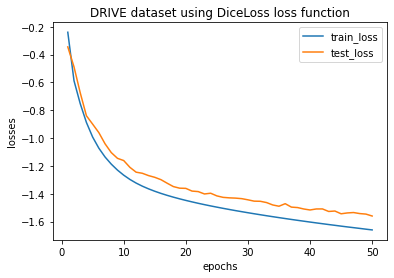

In [ ]:
plt.plot(epochs,train_loss,label = 'train_loss')
plt.plot(epochs,test_loss,label = 'test_loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.title('DRIVE dataset using DiceLoss loss function')
plt.show()

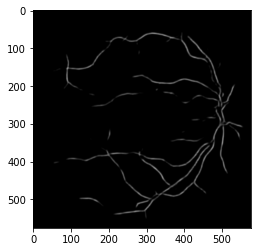

In [ ]:
image, mask = next(iter(test_dataloader))
x_tensor = torch.from_numpy(np.asarray(image)).to(DEVICE).unsqueeze(0)
pred_mask= model(x_tensor[0,:,:,:,:])
pred_mask=pred_mask.detach().squeeze().cpu().numpy()
pred_mask= to_PIL(pred_mask)
plt.imshow(pred_mask)

In [ ]:
model.eval() 
fig,ax = plt.subplots(1,3,figsize = (300,300))
image, mask = next(iter(test_dataloader))
x_tensor = torch.from_numpy(np.asarray(image)).to(DEVICE).unsqueeze(0)
pred_mask= model(x_tensor[0,:,:,:,:])
pred_mask=pred_mask.detach().squeeze().cpu().numpy()
pred_mask= to_PIL(pred_mask)
ax[2].imshow(pred_mask)
image, mask = image.to(DEVICE), mask.to(DEVICE)
true_image= to_PIL(image.cpu()[0])
true_mask = to_PIL(mask.cpu()[0])   
ax[0].imshow(true_image)
ax[1].imshow(true_mask)

  